# Installing DepthAnything for Depth Estimation


In [ ]:
!pip install matplotlib==3.5.2

In [ ]:
from pathlib import Path


repo_dir = Path("Depth-Anything-V2")

if not repo_dir.exists():
    !git clone https://huggingface.co/spaces/depth-anything/Depth-Anything-V2
%cd Depth-Anything-V2

/content/Depth-Anything-V2


In [ ]:
import platform

%pip install -q "openvino>=2024.2.0" "datasets>=2.14.6" "nncf>=2.11.0" "tqdm" "matplotlib>=3.4"
%pip install -q "typing-extensions>=4.9.0" eval-type-backport "gradio>=4.19"
%pip install -q -r requirements.txt --extra-index-url https://download.pytorch.org/whl/cpu

if platform.python_version_tuple()[1] in ["8", "9"]:
    %pip install -q "gradio-imageslider<=0.0.17" "typing-extensions>=4.9.0"

In [ ]:
attention_file_path = Path("./depth_anything_v2/dinov2_layers/attention.py")
orig_attention_path = attention_file_path.parent / ("orig_" + attention_file_path.name)

if not orig_attention_path.exists():
    attention_file_path.rename(orig_attention_path)

    with orig_attention_path.open("r") as f:
        data = f.read()
        data = data.replace("XFORMERS_AVAILABLE = True", "XFORMERS_AVAILABLE = False")
        with attention_file_path.open("w") as out_f:
            out_f.write(data)

In [ ]:
from huggingface_hub import hf_hub_download

encoder = "vits"
model_type = "Small"
model_id = f"depth_anything_v2_{encoder}"

model_path = hf_hub_download(repo_id=f"depth-anything/Depth-Anything-V2-{model_type}", filename=f"{model_id}.pth", repo_type="model")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Downloading nuScenes Dataset

In [ ]:
#Get image from nuscenes

!mkdir -p /data/sets/nuscenes

!wget https://www.nuscenes.org/data/v1.0-mini.tgz

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes

!pip install nuscenes-devkit &> /dev/null

--2024-11-28 04:58:37--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 18.239.69.10, 18.239.69.108, 18.239.69.76, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|18.239.69.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz.1’

v1.0-mini.tgz.1     100%[===================>]   3.88G   238MB/s    in 31s     

2024-11-28 04:59:09 (127 MB/s) - ‘v1.0-mini.tgz.1’ saved [4167696325/4167696325]



# Displaying Sample Images

In [ ]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud
import matplotlib.pyplot as plt
import cv2

# Load the NuScenes dataset
nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

# Choose a sample (example using the first scene and first sample)
sample_token = '3e8750f331d7499e9b5123e9eb70f2e2'
scene = nusc.scene[0]
first_sample_token = scene['first_sample_token']
sample = nusc.get('sample', sample_token)

# Get the front camera data from the sample
cam_front_data = sample['data']['CAM_FRONT']

# Load the image metadata
cam_front = nusc.get('sample_data', cam_front_data)

# Load the image file
image_path = nusc.get_sample_data_path(cam_front_data)
img = cv2.imread(image_path)

#choosing other samples

# Choose a sample (example using the first scene and first sample)
scene2 = nusc.scene[3]
first_sample_token2 = scene['first_sample_token']
sample2 = nusc.get('sample', first_sample_token2)

# Get the front camera data from the sample
cam_front_data2 = sample['data']['CAM_BACK']

# Load the image metadata
cam_front2 = nusc.get('sample_data', cam_front_data2)

# Load the image file
image_path2 = nusc.get_sample_data_path(cam_front_data2)
img2 = cv2.imread(image_path2)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.175 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


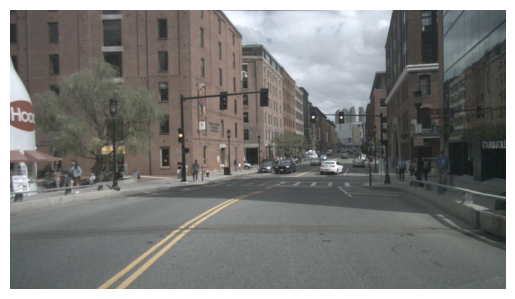

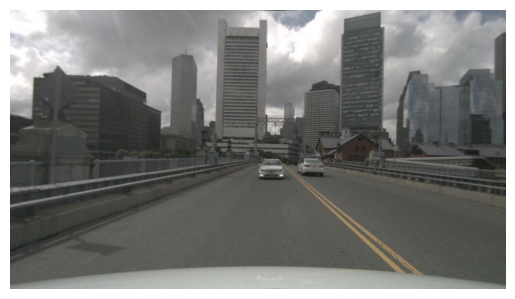

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

from depth_anything_v2.dpt import DepthAnythingV2

model = DepthAnythingV2(encoder=encoder, features=64, out_channels=[48, 96, 192, 384])
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

raw_img = img
image, (h, w) = model.image2tensor(raw_img)
image = image.to("cpu").to(torch.float32)

with torch.no_grad():
    depth = model.forward(image)

depth = F.interpolate(depth[:, None], (h, w), mode="bilinear", align_corners=True)[0, 0]

output = depth.cpu().numpy()

<ipython-input-9-e9f7477e1d53>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cpu"))


# Sample Depth Estimation on nuScenes Image

In [ ]:
predictions = []

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2


def get_depth_map(output, w, h):
    depth = cv2.resize(output, (w, h))

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)

    depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

    return depth

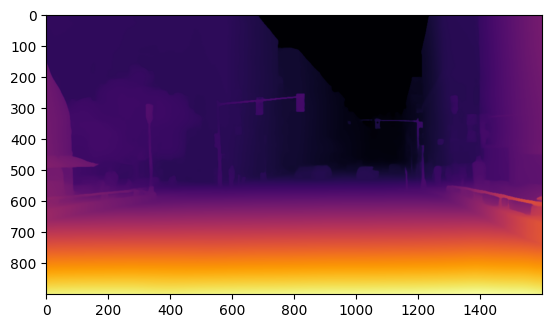

In [ ]:
h, w = raw_img.shape[:-1]
res_depth = get_depth_map(output, w, h)
plt.imshow(res_depth[:, :, ::-1])

# Downloading Detectron2 Model for 2D Object Detection

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [ ]:
!pip install open3d

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Running Detectron2 On Sample nuScenes Image

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

[11/28 05:00:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 2,  2,  0,  0,  0,  0,  2,  2,  9,  2,  0,  2,  2,  0,  9,  9,  0,  9,
         9,  0,  0,  0,  2,  0,  2,  2,  9,  2, 13], device='cuda:0')
Boxes(tensor([[ 998.8866,  485.0367, 1073.8413,  532.2197],
        [ 851.2223,  481.6171,  922.9569,  528.9479],
        [ 586.7052,  481.7485,  611.9662,  553.5181],
        [ 182.9520,  484.9104,  233.3152,  593.4002],
        [1248.6003,  474.8431, 1275.8895,  552.0666],
        [1369.3811,  448.3259, 1419.3422,  590.9349],
        [ 798.1127,  479.7383,  858.1942,  525.7597],
        [1103.7921,  477.2254, 1143.9264,  509.6686],
        [1058.6100,  324.6625, 1079.6543,  368.2775],
        [ 999.7045,  465.3448, 1023.8610,  485.4477],
        [1286.9614,  485.8811, 1307.5614,  536.1194],
        [ 968.8849,  474.0733, 1004.1066,  500.5361],
        [1067.3878,  458.6515, 1092.0251,  480.0433],
        [ 537.8906,  486.6111,  555.5975,  543.9516],
        [ 540.9681,  381.4456,  560.6694,  432.1948],
        [ 674.7356,  263.4617,  70

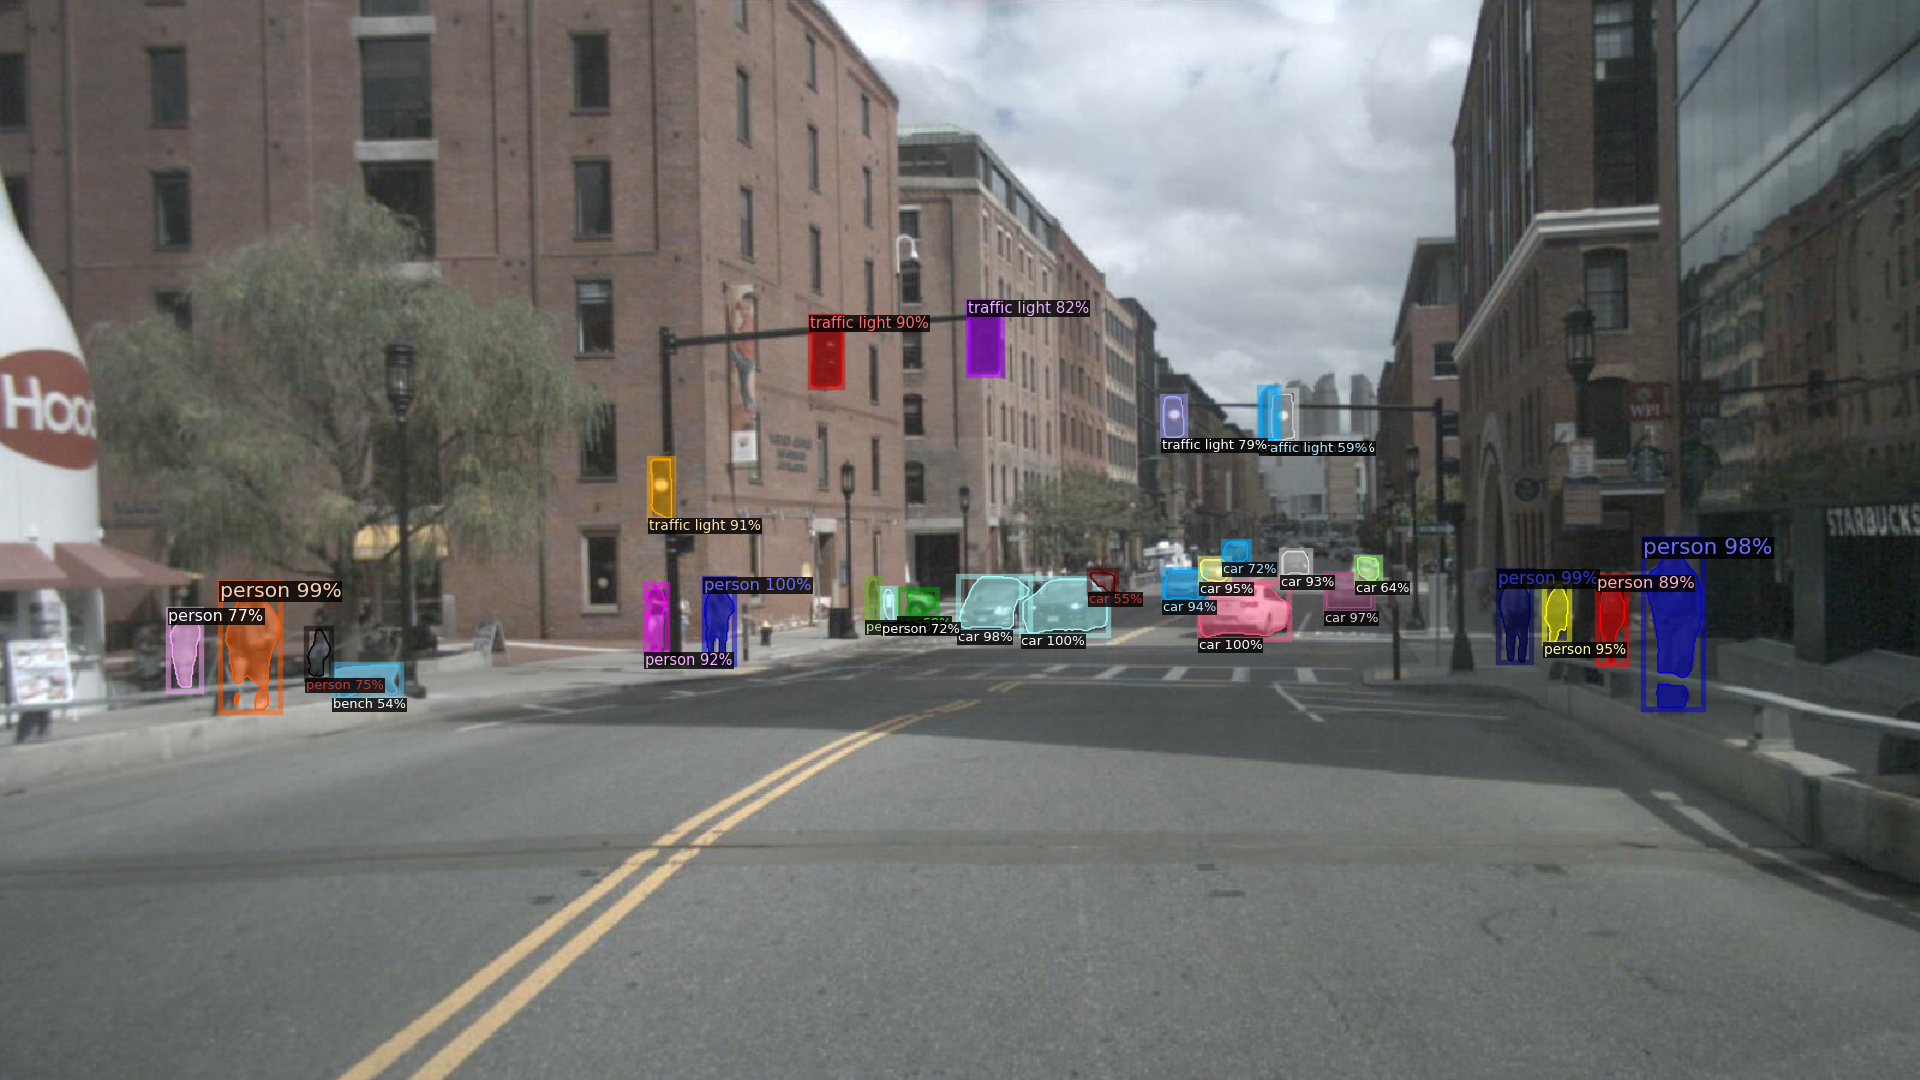

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

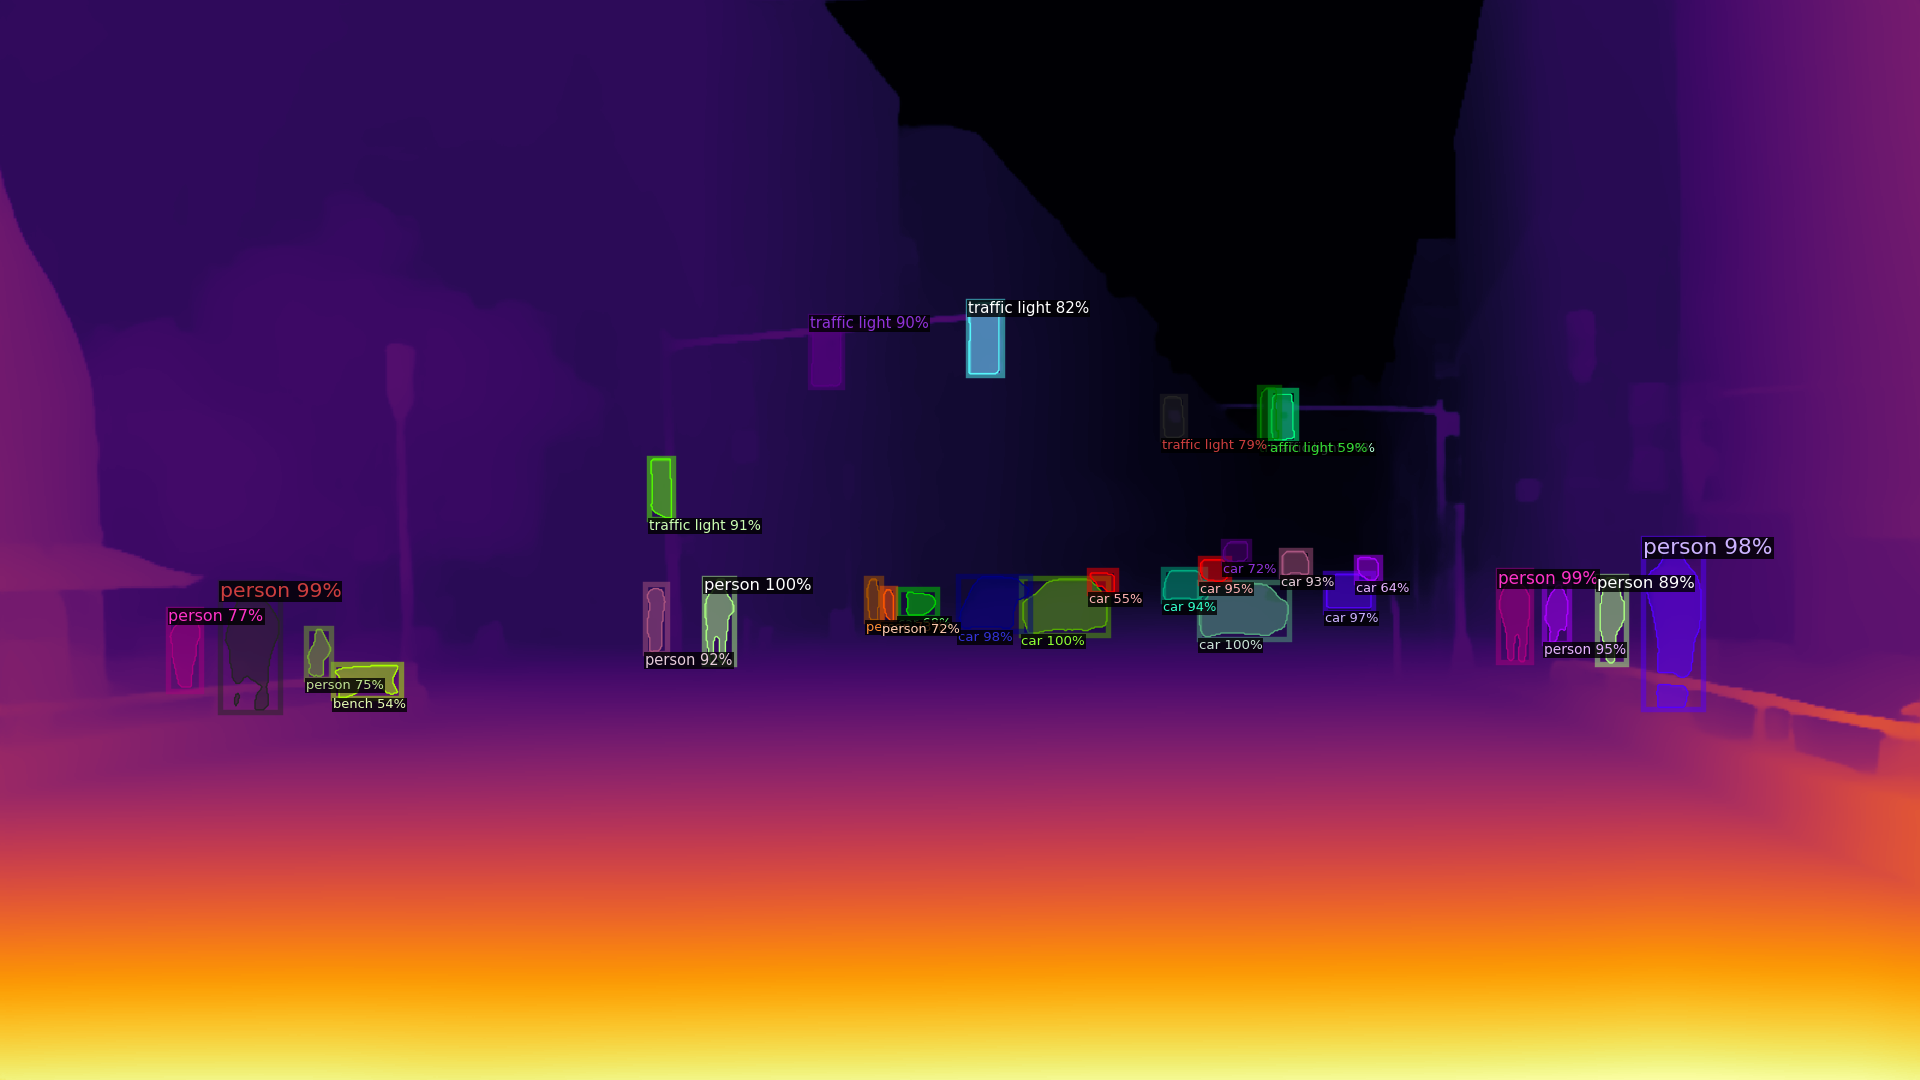

In [ ]:
#drawing bounding box on depth map
v = Visualizer(res_depth[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Calculating Median Depths Based on Segmentation Masks

In [ ]:
# print out median depths
masks = outputs["instances"].pred_masks if outputs["instances"].has("pred_masks") else None

median_depths = []
for i, mask in enumerate(masks):
    mask = mask.to("cpu").numpy()

    object_depth_values = res_depth[mask].flatten()

    object_depth_values = object_depth_values[object_depth_values > 0]

    if len(object_depth_values) > 0:
        median_depth = np.median(object_depth_values)
        median_depths.append(median_depth)
        print(f"Object {i} - Median Depth: {median_depth}")
    else:
        print(f"Object {i} has no valid depth values.")

Object 0 - Median Depth: 36.0
Object 1 - Median Depth: 35.0
Object 2 - Median Depth: 52.0
Object 3 - Median Depth: 71.0
Object 4 - Median Depth: 57.0
Object 5 - Median Depth: 76.0
Object 6 - Median Depth: 28.0
Object 7 - Median Depth: 18.0
Object 8 - Median Depth: 16.0
Object 9 - Median Depth: 8.0
Object 10 - Median Depth: 50.0
Object 11 - Median Depth: 12.0
Object 12 - Median Depth: 4.0
Object 13 - Median Depth: 45.0
Object 14 - Median Depth: 57.0
Object 15 - Median Depth: 59.0
Object 16 - Median Depth: 57.0
Object 17 - Median Depth: 69.0
Object 18 - Median Depth: 5.0
Object 19 - Median Depth: 73.0
Object 20 - Median Depth: 69.0
Object 21 - Median Depth: 25.0
Object 22 - Median Depth: 3.0
Object 23 - Median Depth: 24.0
Object 24 - Median Depth: 22.0
Object 25 - Median Depth: 6.0
Object 26 - Median Depth: 3.0
Object 27 - Median Depth: 12.0
Object 28 - Median Depth: 87.0


In [ ]:
!pip install open3d plotly

#Getting Camera Calibration Data from nuScenes

In [ ]:
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from pyquaternion import Quaternion
import numpy as np

def get_camera_intrinsics(nusc, sample_data_token):
    calibrated_sensor = nusc.get('calibrated_sensor', nusc.get('sample_data', sample_data_token)['calibrated_sensor_token'])
    return np.array(calibrated_sensor['camera_intrinsic'])

def get_camera_extrinsics(nusc, sample_data_token):
    calibrated_sensor = nusc.get('calibrated_sensor', nusc.get('sample_data', sample_data_token)['calibrated_sensor_token'])

    rotation = np.array(calibrated_sensor['rotation'])
    translation = np.array(calibrated_sensor['translation'])

    rotation_matrix = Quaternion(rotation).rotation_matrix
    extrinsic_matrix = np.eye(4)
    extrinsic_matrix[:3, :3] = rotation_matrix
    extrinsic_matrix[:3, 3] = translation
    return extrinsic_matrix

**Finding Center Points of Segmentation Masks**

In [ ]:
from scipy.ndimage import center_of_mass

def get_center_of_segmentation_mask(masks):
  centers = []
  for mask in masks:
    mask = mask.to("cpu").numpy()
    center = center_of_mass(mask)
    centers.append(center)
  return centers

**Backprojection from 2D to 3D**

In [ ]:
import plotly.graph_objects as go

def back_project_2d_to_3d(center_2d, depth, intrinsic_matrix):
    center_2d_homogeneous = np.array([center_2d[0], center_2d[1], 1.0])

    center_3d_camera = depth * np.linalg.inv(intrinsic_matrix).dot(center_2d_homogeneous)
    return center_3d_camera

def transform_to_world_coordinates(point_3d_camera, extrinsic_matrix):
    point_3d_camera_homogeneous = np.append(point_3d_camera, 1.0)

    point_3d_world = extrinsic_matrix.dot(point_3d_camera_homogeneous)
    return point_3d_world[:3]

import open3d as o3d

def create_point_cloud(points):
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    return point_cloud

def visualize_point_cloud(points):
    fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8)
    )])
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        width=800,
        height=800)
    fig.show()


**Visualizing Point Cloud for Sample nuScenes Image**

In [ ]:
scene = nusc.scene[0]
first_sample_token = scene['first_sample_token']
first_sample = nusc.get('sample', first_sample_token)

sample_data_token = first_sample['data']['CAM_FRONT']

intrinsic = get_camera_intrinsics(nusc, sample_data_token)
extrinsic = get_camera_extrinsics(nusc, sample_data_token)

print("Intrinsic matrix (camera calibration):", intrinsic)
print("Extrinsic matrix (world to camera transformation):", extrinsic)

center_2d = get_center_of_segmentation_mask(masks)

center_3d_world_list = []

for i in range(0,len(center_2d)):
    center_3d_camera = back_project_2d_to_3d(center_2d[i], median_depths[i], intrinsic)
    center_3d_world = transform_to_world_coordinates(center_3d_camera, extrinsic)
    center_3d_world_list.append(center_3d_world)

points_3d = np.array(center_3d_world_list)

visualize_point_cloud(points_3d)

#project back onto image to check if in center

Intrinsic matrix (camera calibration): [[1.26641720e+03 0.00000000e+00 8.16267020e+02]
 [0.00000000e+00 1.26641720e+03 4.91507066e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Extrinsic matrix (world to camera transformation): [[ 5.68477868e-03 -5.63666773e-03  9.99967955e-01  1.70079119e+00]
 [-9.99983517e-01 -8.37115272e-04  5.68014846e-03  1.59456324e-02]
 [ 8.05071338e-04 -9.99983763e-01 -5.64133364e-03  1.51095764e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


**Converting 3D Point Cloud to Bird's Eye View**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_bev(points, grid_size, range_x, range_y):
    bev_grid = np.zeros((grid_size[1], grid_size[0]))

    for point in points:
        x, y, z = point

        grid_x = int((x - range_x[0]) / (range_x[1] - range_x[0]) * grid_size[0])
        grid_y = int((y - range_y[0]) / (range_y[1] - range_y[0]) * grid_size[1])

        if 0 <= grid_x < grid_size[0] and 0 <= grid_y < grid_size[1]:
            bev_grid[grid_y, grid_x] += 1

    return bev_grid

def visualize_bev(bev_grid):
    plt.imshow(bev_grid, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Point Count')
    plt.xlabel('X Grid Index')
    plt.ylabel('Y Grid Index')
    plt.title('Bird\'s Eye View')
    plt.show()

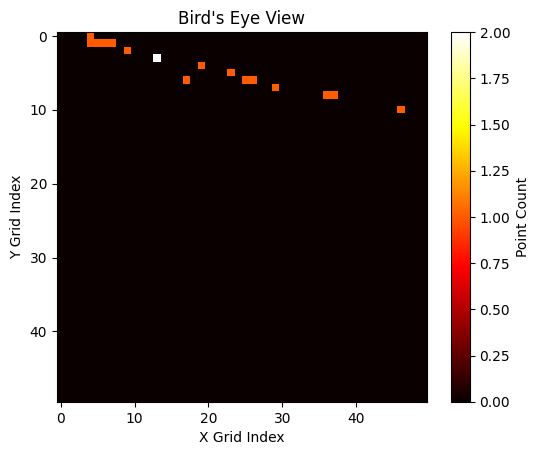

In [ ]:
grid_size = (50, 50)
range_x = (0, 50)
range_y = (0, 50)

bev_grid = convert_to_bev(points_3d, grid_size, range_x, range_y)

visualize_bev(bev_grid)

#Implementing 3D Cuboids with Heuristics


In [ ]:
COCO_CLASSES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork",
    "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
    "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "TV",
    "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

pred_classes = outputs["instances"].pred_classes
pred_class_names = [COCO_CLASSES[i] for i in pred_classes]
for i in pred_class_names:
  print(i)

car
car
person
person
person
person
car
car
traffic light
car
person
car
car
person
traffic light
traffic light
person
traffic light
traffic light
person
person
person
car
person
car
car
traffic light
car
bench


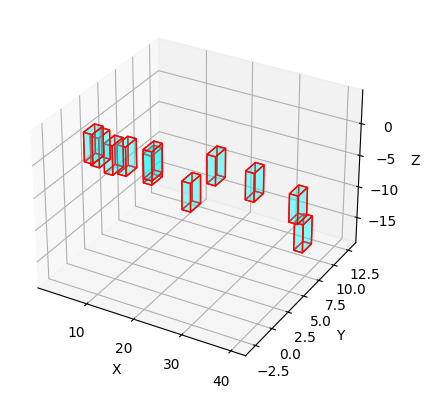

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Average dimensions for cars and trucks in meters (Width, Height, Length)
average_dimensions = {
    'car': (1.8, 4.5, 1.5),
    'truck': (2.5, 8.0, 3.0)
}

cuboids = []

for i, category in enumerate(pred_class_names):
    if category in average_dimensions:
        width, height, length = average_dimensions[category]
        center_point = center_3d_world_list[i]

        cuboids.append((center_point, width, height, length))

def plot_multiple_cuboids(cuboids):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for cuboid in cuboids:
        center, width, height, length = cuboid
        x_c, y_c, z_c = center
        dx = width / 2
        dy = length / 2
        dz = height / 2

        vertices = np.array([
            [x_c - dx, y_c - dy, z_c - dz],
            [x_c + dx, y_c - dy, z_c - dz],
            [x_c + dx, y_c + dy, z_c - dz],
            [x_c - dx, y_c + dy, z_c - dz],
            [x_c - dx, y_c - dy, z_c + dz],
            [x_c + dx, y_c - dy, z_c + dz],
            [x_c + dx, y_c + dy, z_c + dz],
            [x_c - dx, y_c + dy, z_c + dz]
        ])

        faces = [
            [vertices[0], vertices[1], vertices[2], vertices[3]],  # Bottom face
            [vertices[4], vertices[5], vertices[6], vertices[7]],  # Top face
            [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face
            [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face
            [vertices[1], vertices[2], vertices[6], vertices[5]],  # Right face
            [vertices[0], vertices[3], vertices[7], vertices[4]]   # Left face
        ]

        ax.add_collection3d(Poly3DCollection(faces, facecolors="cyan", linewidths=1, edgecolors="r", alpha=.25))

    all_x = [center[0] for center, _, _, _ in cuboids]
    all_y = [center[1] for center, _, _, _ in cuboids]
    all_z = [center[2] for center, _, _, _ in cuboids]
    max_dim = max([width for _, width, _, _ in cuboids] + [length for _, _, length, _ in cuboids] + [height for _, _, _, height in cuboids])

    ax.set_xlim(min(all_x) - max_dim, max(all_x) + max_dim)
    ax.set_ylim(min(all_y) - max_dim, max(all_y) + max_dim)
    ax.set_zlim(min(all_z) - max_dim, max(all_z) + max_dim)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

plot_multiple_cuboids(cuboids)



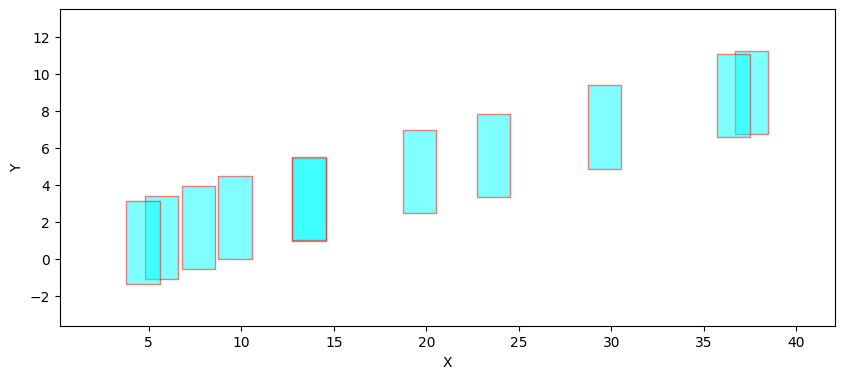

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def plot_multiple_cuboids_2d(cuboids):
    fig, ax = plt.subplots(figsize=(10, 10))

    patches = []

    for cuboid in cuboids:
        center, width, length, height = cuboid
        x_c, y_c, _ = center
        dx = width / 2
        dy = length / 2

        vertices = np.array([
            [x_c - dx, y_c - dy],
            [x_c + dx, y_c - dy],
            [x_c + dx, y_c + dy],
            [x_c - dx, y_c + dy]
        ])

        polygon = Polygon(vertices, closed=True)
        patches.append(polygon)

    p = PatchCollection(patches, facecolor="cyan", edgecolor="r", alpha=0.5)
    ax.add_collection(p)

    all_x = [center[0] for center, _, _, _ in cuboids]
    all_y = [center[1] for center, _, _, _ in cuboids]
    max_dim = max([width for _, width, _, _ in cuboids] + [length for _, _, length, _ in cuboids])

    ax.set_xlim(min(all_x) - max_dim, max(all_x) + max_dim)
    ax.set_ylim(min(all_y) - max_dim, max(all_y) + max_dim)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', 'box')

    plt.show()

plot_multiple_cuboids_2d(cuboids)
#plot w. width and length
#add box/dot that represents autonomous vehicle
#plot nuscenes ground truth cuboids and compare with generated 3d cuboids
#nuscenes stops at 30m

#orientation: use map prior lane markings/lines
#

Ground Truth Lidar Image

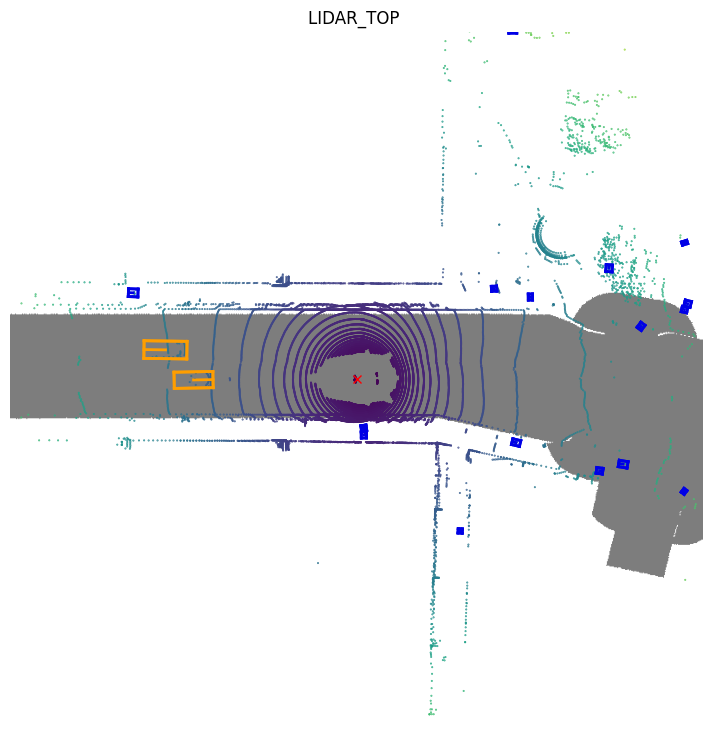

In [ ]:
nusc.render_sample_data(sample['data']['LIDAR_TOP'], nsweeps=5, underlay_map=True)
#challenging scene due to orientation of av
#pick example w. straight orientation
#(INSTEAD OF 3D CUBOIDS) plot BEV prediction boxes onto the ground truth
#see if we can get uncropped lidar plot
#query for closest lane line to center point, apply that to orient

# **Finding Metrics**

In [ ]:
def translate_to_global(local_translation, ego_translation, ego_rotation):
    """
    Converts a local translation to global coordinates based on ego pose.

    Args:
        local_translation (list or np.array): Local [x, y, z] translation in the ego vehicle's frame.
        ego_translation (list or np.array): Ego vehicle's [x, y, z] position in the global frame.
        ego_rotation (list): Ego vehicle's rotation as a quaternion [w, x, y, z].

    Returns:
        list: Translated [x, y, z] in the global coordinate system.
    """
    local_translation = np.array(local_translation)
    ego_translation = np.array(ego_translation)
    ego_rotation = Quaternion(ego_rotation)

    global_translation = ego_rotation.rotate(local_translation) + ego_translation

    global_translation[2] = max(global_translation[2], 0.8) + 2  # z value seems off, so using 0.8 which is a typical ground truth z value

    return global_translation.tolist()

**Finding metrics for a single token**

In [ ]:
import json

scores = outputs["instances"].scores.tolist()

default_quaternion = [1, 0, 0, 0]

results = {}

for i, item in enumerate(cuboids):
    position, width, length, height = item

    sample_data_token = sample['data']['CAM_FRONT']
    sample_data = nusc.get('sample_data', sample_data_token)
    ego_pose = nusc.get('ego_pose', sample_data['ego_pose_token'])

    ego_translation = ego_pose['translation']
    ego_rotation = ego_pose['rotation']

    print(translate_to_global(position.tolist(), ego_translation, ego_rotation))
    formatted_prediction = {
        "sample_token": sample_token,
        "translation": translate_to_global(position.tolist(), ego_translation, ego_rotation),
        "size": [width, length, height],
        "rotation": default_quaternion,
        "velocity": [0.0, 0.0],
        "detection_name": pred_class_names[i],
        "detection_score": scores[i],
        "attribute_name": ""
    }
    if pred_class_names[i] != 'person' and pred_class_names[i] != 'traffic light':
      if sample_token not in results:
        results[sample_token] = []
      results[sample_token].append(formatted_prediction)

output_json = {
    "meta": {
        "use_camera": True,
        "use_lidar": False,
        "use_radar": False,
        "use_map": False,
        "use_external": False
    },
    "results": results
}

output_path = '/content/predictions.json'
with open(output_path, 'w') as f:
    json.dump(output_json, f, indent=2)

print(f"Predictions saved to {output_path}")

[636.9169628495954, 1637.6601969152377, 2.8]
[636.0410667027352, 1637.9221948795982, 2.8]
[629.1679099898297, 1639.7492582862008, 2.8]
[619.2227416281444, 1642.4489124394493, 2.8]
[609.3717511263832, 1644.967993763815, 2.8]
[613.3204460975617, 1643.9329081661554, 2.8]
[605.375172011096, 1645.9130902395666, 2.8]
[604.3866269006357, 1646.1580994330727, 2.8]
[623.2244028096742, 1641.237666958819, 2.8]
[607.3636896098938, 1645.4469619310828, 2.8]
[613.3485810947071, 1643.9543895322358, 2.8]
Predictions saved to /content/predictions.json


**Finding the sample tokens that are in mini-val dataset (nuScenes needs the tokens to match between splits), adding dummy entries**

In [ ]:
scene_names = ['scene-0103', 'scene-0916']


scene_sample_tokens = {}

for scene in nusc.scene:
    if scene['name'] in scene_names:
        sample_token = scene['first_sample_token']
        scene_sample_tokens[scene['name']] = []
        while sample_token:
            scene_sample_tokens[scene['name']].append(sample_token)
            sample = nusc.get('sample', sample_token)
            sample_token = sample['next']

all_scene_tokens = [token for tokens in scene_sample_tokens.values() for token in tokens]

predictions_path = '/content/predictions.json'
with open(predictions_path, 'r') as f:
    predictions = json.load(f)

if 'results' not in predictions:
    predictions['results'] = {}

# Add dummy entries for tokens that are missing
missing_tokens = set(all_scene_tokens) - set(predictions['results'].keys())
for token in missing_tokens:
    predictions['results'][token] = []

updated_predictions_path = '/content/updated_predictions.json'
with open(updated_predictions_path, 'w') as f:
    json.dump(predictions, f, indent=2)

print(f"Updated predictions saved to {updated_predictions_path}")
print(f"Total number of dummy tokens added: {len(missing_tokens)}")

Updated predictions saved to /content/updated_predictions.json
Total number of dummy tokens added: 80


**Generated Metrics with predictions for single token (dummy entries for the rest)**

In [ ]:
from nuscenes.eval.detection.evaluate import DetectionEval
from nuscenes.eval.detection.config import config_factory
from nuscenes.nuscenes import NuScenes

import matplotlib
print(matplotlib.__version__)

config = config_factory('detection_cvpr_2019')
detection_eval = DetectionEval(
    nusc,
    config=config,
    result_path='/content/updated_predictions.json',
    eval_set='mini_val',
    output_dir='/content/evaluation'
)

metrics_summary = detection_eval.main(render_curves=False)
print(metrics_summary)

3.5.2
Initializing nuScenes detection evaluation
Loaded results from /content/updated_predictions.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 308.39it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 5
=> After distance based filtering: 5
=> After LIDAR and RADAR points based filtering: 5
=> After bike rack filtering: 5
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR and RADAR points based filtering: 3393
=> After bike rack filtering: 3393
Accumulating metric data...
Calculating metrics...
Saving metrics to: /content/evaluation
mAP: 0.0000
mATE: 1.0000
mASE: 1.0000
mAOE: 1.0000
mAVE: 1.0000
mAAE: 1.0000
NDS: 0.0000
Eval time: 0.0s

Per-class results:
Object Class        	AP    	ATE   	ASE   	AOE   	AVE   	AAE   
car                 	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
truck               	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
bus                 	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
trailer             	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
construction_vehicle	0.000 	1.000 	1.000 	1.000 	1.

In [ ]:
from nuscenes.utils.splits import create_splits_scenes

scene_splits = create_splits_scenes()

mini_val_scenes = scene_splits['mini_val']

print("Scenes in the mini_val split:")
for scene in mini_val_scenes:
    print(scene)


Scenes in the mini_val split:
scene-0103
scene-0916


# **Generating predictions for all scenes in mini-val**

Predictions saved to /content/allpredictions.json


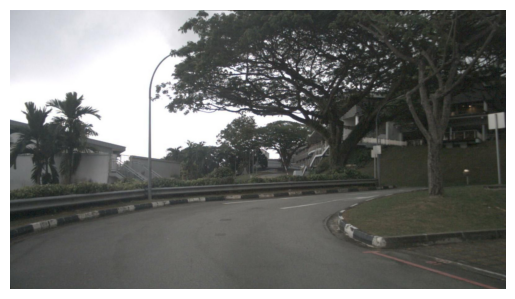

In [ ]:
results = {}

for token in all_scene_tokens:
  sample = nusc.get('sample', token)
  cam_front_data = sample['data']['CAM_FRONT']

  cam_front = nusc.get('sample_data', cam_front_data)

  image_path = nusc.get_sample_data_path(cam_front_data)
  img = cv2.imread(image_path)

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  # plt.show()

  raw_img = img
  image, (h, w) = model.image2tensor(raw_img)
  image = image.to("cpu").to(torch.float32)

  with torch.no_grad():
      depth = model.forward(image)

  depth = F.interpolate(depth[:, None], (h, w), mode="bilinear", align_corners=True)[0, 0]

  output = depth.cpu().numpy()

  h, w = raw_img.shape[:-1]
  res_depth = get_depth_map(output, w, h)
  # plt.imshow(res_depth[:, :, ::-1])

  outputs = predictor(img)

  v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # cv2_imshow(out.get_image()[:, :, ::-1])

  v = Visualizer(res_depth[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # cv2_imshow(out.get_image()[:, :, ::-1])

  masks = outputs["instances"].pred_masks if outputs["instances"].has("pred_masks") else None

  median_depths = []
  for i, mask in enumerate(masks):
      mask = mask.to("cpu").numpy()

      object_depth_values = res_depth[mask].flatten()

      object_depth_values = object_depth_values[object_depth_values > 0]

      if len(object_depth_values) > 0:
          median_depth = np.median(object_depth_values)
          median_depths.append(median_depth)
          # print(f"Object {i} - Median Depth: {median_depth}")

  intrinsic = get_camera_intrinsics(nusc, cam_front_data)
  extrinsic = get_camera_extrinsics(nusc, cam_front_data)

  # print("Intrinsic matrix (camera calibration):", intrinsic)
  # print("Extrinsic matrix (world to camera transformation):", extrinsic)

  center_2d = get_center_of_segmentation_mask(masks)

  center_3d_world_list = []

  for i in range(0,len(center_2d)):
      center_3d_camera = back_project_2d_to_3d(center_2d[i], median_depths[i], intrinsic)
      center_3d_world = transform_to_world_coordinates(center_3d_camera, extrinsic)
      center_3d_world_list.append(center_3d_world)

  points_3d = np.array(center_3d_world_list)

  # visualize_point_cloud(points_3d)

  pred_classes = outputs["instances"].pred_classes
  pred_class_names = [COCO_CLASSES[i] for i in pred_classes]

  cuboids = []

  for i, category in enumerate(pred_class_names):
      if category in average_dimensions:
          width, height, length = average_dimensions[category]
          center_point = center_3d_world_list[i]

          cuboids.append((center_point, width, height, length))

  scores = outputs["instances"].scores.tolist()

  results[token] = []
  for i, item in enumerate(cuboids):
    position, width, length, height = item

    formatted_prediction = {
        "sample_token": token,
        "translation": position.tolist(),
        "size": [width, length, height],
        "rotation": default_quaternion,
        "velocity": [0.0, 0.0],
        "detection_name": pred_class_names[i],
        "detection_score": scores[i],
        "attribute_name": ""
    }

    if pred_class_names[i] in average_dimensions:
      results[token].append(formatted_prediction)


output_json = {
  "meta": {
      "use_camera": True,
      "use_lidar": False,
      "use_radar": False,
      "use_map": False,
      "use_external": False
  },
  "results": results
}

output_path = '/content/allpredictions.json'
with open(output_path, 'w') as f:
    json.dump(output_json, f, indent=2)

print(f"Predictions saved to {output_path}")

**Generating metrics for all predictions**

In [ ]:
config = config_factory('detection_cvpr_2019')

detection_eval = DetectionEval(
    nusc,
    config=config,
    result_path='/content/allpredictions.json',
    eval_set='mini_val',
    output_dir='/content/allevaluation'
)


metrics_summary = detection_eval.main(render_curves=False)
print(metrics_summary)

Initializing nuScenes detection evaluation
Loaded results from /content/allpredictions.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 301.33it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 916
=> After distance based filtering: 0
=> After LIDAR and RADAR points based filtering: 0
=> After bike rack filtering: 0
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR and RADAR points based filtering: 3393
=> After bike rack filtering: 3393
Accumulating metric data...
Calculating metrics...
Saving metrics to: /content/allevaluation
mAP: 0.0000
mATE: 1.0000
mASE: 1.0000
mAOE: 1.0000
mAVE: 1.0000
mAAE: 1.0000
NDS: 0.0000
Eval time: 0.0s

Per-class results:
Object Class        	AP    	ATE   	ASE   	AOE   	AVE   	AAE   
car                 	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
truck               	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
bus                 	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
trailer             	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
construction_vehicle	0.000 	1.000 	1.000 	1.00